In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm
from itertools import product
from sklearn.linear_model import LinearRegression



%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

def kmer_dict(n):
  kmer_encoding = {}
  for i, kmer in enumerate(product(['a', 'c', 'g', 't'], repeat=n)):
    zeros = [0] * 4 ** n
    zeros[i] = 1
    kmer_encoding["".join(kmer)] = zeros
  return kmer_encoding

def featurize(df, k, col='utr'):
  nuc_d = kmer_dict(k)
  seq_len = len(df['utr'][0])
  vectors = np.empty([len(df), seq_len - k  + 1, 4 ** k])
  
  for i, seq in tqdm(enumerate(df[col].astype(str))):
    seq = seq.lower()
    encoding = []
    for j in range(seq_len - k + 1):
      encoding.append(nuc_d[seq[j:j + k]])
    vectors[i] = np.array(encoding)
  return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def valid_predict(train_df, valid_df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df_copy = valid_df.copy()
    df_copy.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df_copy

def evaluate_model(model, train_x, valid_x, train_df, valid_df):
    print(f"Train R-squared: {model.score(train_x, train_df['scaled_rl'])}")
    valid = valid_predict(train_df=train_df, valid_df=valid_df, model=model, obs_col='rl',test_seq=valid_x)
    r = r2(valid_df['scaled_rl'], valid['pred'])
    print(f"Validation R-squared: {r}")
    atg = valid[valid['utr'].apply(lambda x: 'ATG' in x)]
    n_atg = valid[valid['utr'].apply(lambda x: 'ATG' not in x)]
    print("Validation R-squared uATG: ", r2(atg['rl'], atg['pred']))
    print("Validation R-squared no uATG: ", r2(n_atg['rl'], n_atg['pred']))
    c1 = (0.3, 0.45, 0.69)
    c2 = 'r'
    g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, height=7)
    g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1))
    ax.set_yticklabels(range(10),size=20)
    ax.set_xticks(np.arange(1,10.01, 1))
    ax.set_xticklabels(range(1,11),size=20)
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    g.x = n_atg['rl'].values
    g.y = n_atg['pred'].values
    g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
    g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
    f = g.fig
  

### Load data, make train and test sets with same proportion of uAUG UTRs
The test set used by the authors contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR. However, sequences with a uAUG are enriched in the set of 20,000 UTRs with the most reads, so we'll split in a way that keeps the proportion of uATG the same. Data has already been split and saved, so load these saved files.

In [2]:
train = pd.read_csv('../data/egfp_unmod_1_split/train.csv')
valid = pd.read_csv('../data/egfp_unmod_1_split/valid.csv')
train_one_hot = np.load('../data/egfp_unmod_1_split/onehot_train.npy')
valid_one_hot = np.load('../data/egfp_unmod_1_split/onehot_valid.npy')

Flatten one-hot encoded sequences so they can be used as features for regression.

In [3]:
train_one_hot = train_one_hot.reshape(224000, 200)
valid_one_hot = valid_one_hot.reshape(28000, 200)


### Train model
Fit OLS on the training set of flattened one-hot encoded sequences.

In [4]:
reg = LinearRegression().fit(train_one_hot, train['scaled_rl'])

Evaluate the model:

Train R-squared: 0.07807036966736658
Validation R-squared: 0.08577558336743388
Validation R-squared uATG:  0.16026416736446747
Validation R-squared no uATG:  0.04347479363994119


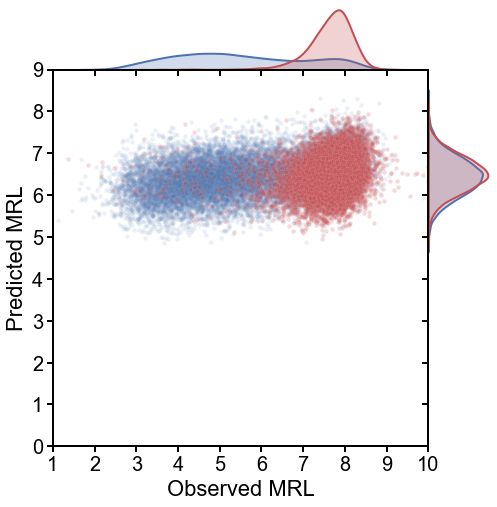

In [5]:
evaluate_model(model=reg, train_x=train_one_hot, valid_x=valid_one_hot, train_df=train, valid_df=valid)

Try with more features: position and identity of dinucleotides and trinucleotides.

In [6]:
train_dinuc = featurize(train, 2)
valid_dinuc = featurize(valid, 2)

train_trinuc = featurize(train, 3)
valid_trinuc = featurize(valid, 3)

224000it [00:11, 19378.58it/s]
28000it [00:01, 18770.23it/s]
224000it [00:35, 6270.42it/s]
28000it [00:04, 6372.37it/s]


In [7]:
print(len(train_dinuc[0]) * len(train_dinuc[0][0]))
print(len(train_trinuc[0]) * len(train_trinuc[0][0]))

784
3072


In [8]:
train_dinuc = train_dinuc.reshape(224000, 784)
valid_dinuc = valid_dinuc.reshape(28000, 784)
train_trinuc = train_trinuc.reshape(224000, 3072)
valid_trinuc = valid_trinuc.reshape(28000, 3072)

Use just dinucleotide position and identity as features:

Train R-squared: 0.29093500069959044
Validation R-squared: 0.29675679176323955
Validation R-squared uATG:  0.22837123880475957
Validation R-squared no uATG:  0.049594828328781225


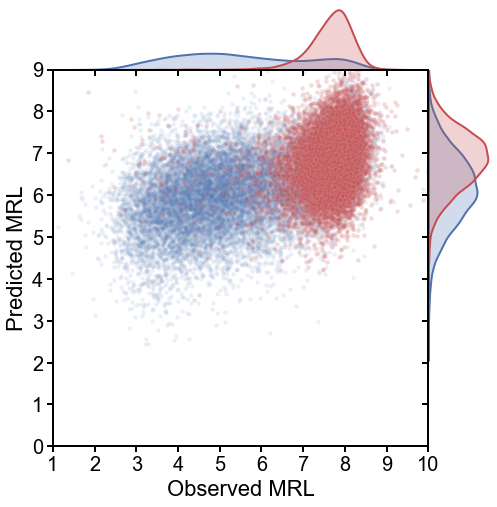

In [9]:
reg = LinearRegression().fit(train_dinuc, train['scaled_rl'])
evaluate_model(model=reg, train_x=train_dinuc, valid_x=valid_dinuc, train_df=train, valid_df=valid)

Use just trinucleotide position and identity as features:

Train R-squared: 0.6215769412896867
Validation R-squared: 0.6183382165125633
Validation R-squared uATG:  0.4187369569905405
Validation R-squared no uATG:  0.1933210874398612


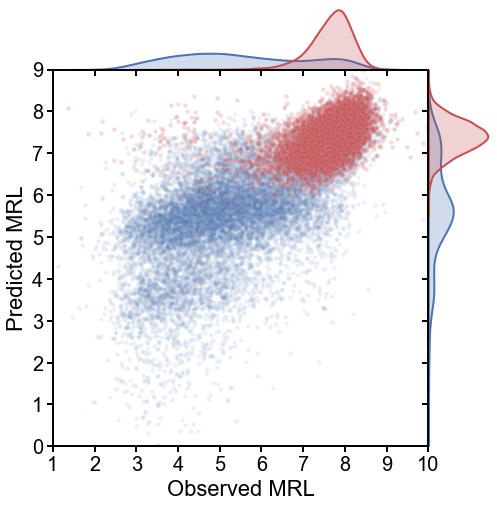

In [10]:
reg = LinearRegression().fit(train_trinuc, train['scaled_rl'])
evaluate_model(model=reg, train_x=train_trinuc, valid_x=valid_trinuc, train_df=train, valid_df=valid)

Use mono-, di-, and trinucleotide position and identity as features:

In [11]:
train_features = np.concatenate((train_one_hot, train_dinuc), axis=1)
del train_one_hot
del train_dinuc
train_features = np.concatenate((train_features, train_trinuc), axis=1)
del train_trinuc

valid_features = np.concatenate((valid_one_hot, valid_dinuc), axis=1)
del valid_one_hot
del valid_dinuc
valid_features = np.concatenate((valid_features, valid_trinuc), axis=1)
del valid_trinuc

Train R-squared: 0.6212415690269174
Validation R-squared: 0.6184576705737169
Validation R-squared uATG:  0.41805623562047317
Validation R-squared no uATG:  0.19560490549814452


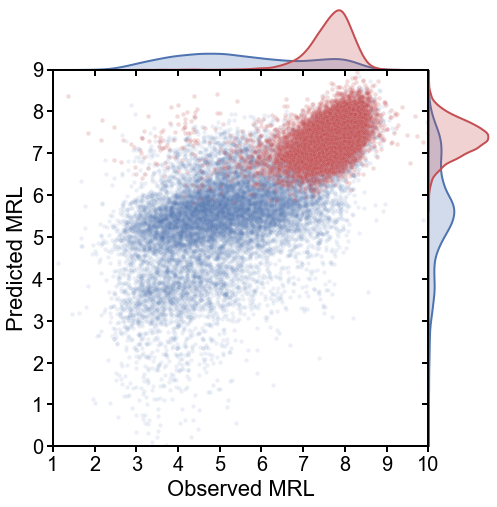

In [12]:
reg = LinearRegression().fit(train_features, train['scaled_rl'])
evaluate_model(model=reg, train_x=train_features, valid_x=valid_features, train_df=train, valid_df=valid)

In [ ]:
del train_features
del valid_features

In [ ]:
def atg_featurize(df, col='utr'):
  seq_len = len(df['utr'][0])
  vectors = np.empty([len(df), seq_len - 2])
  
  for i, seq in tqdm(enumerate(df[col].astype(str))):
    seq = seq.lower()
    encoding = [0]*(seq_len - 2)
    for j in range(seq_len):
      if seq[j:j + 3] == "atg":
        encoding[j] = 1
    vectors[i] = np.array(encoding)
  return vectors

test_df = pd.DataFrame({'utr': ['ATGC', 'GTCA', 'TTCG'], 'rl': [3, 4, 5]})

atg_featurize(test_df)

In [ ]:
train_atg_features = atg_featurize(train)
valid_atg_features = atg_featurize(valid)

In [ ]:
reg = LinearRegression().fit(train_atg_features, train['scaled_rl'])
reg.score(train_atg_features, train['scaled_rl'])

In [ ]:
valid = valid_predict(train_df=train, valid_df=valid, model=reg, obs_col='rl',test_seq=valid_atg_features)
pred = reg.predict(valid_atg_features)
r = r2(valid['scaled_rl'], valid['pred'])
print('r-squared = ', r)
atg = valid[valid['utr'].apply(lambda x: 'ATG' in x)]
n_atg = valid[valid['utr'].apply(lambda x: 'ATG' not in x)]
print("uATG: ", r2(atg['rl'], atg['pred']))
print("no uATG: ", r2(n_atg['rl'], n_atg['pred']))

In [ ]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, height=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1))
ax.set_yticklabels(range(10),size=20)
ax.set_xticks(np.arange(1,10.01, 1))
ax.set_xticklabels(range(1,11),size=20)
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig